# UTCI: Mapping Thermal Stress

Tmrt tells you how much radiation a person absorbs, but thermal comfort also depends on
air temperature, humidity, and wind. This tutorial computes **UTCI** thermal
comfort maps for a hot Athens afternoon and visualises them using stress-category colour scales.


In [ ]:
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import solweig
from matplotlib.colors import BoundaryNorm, ListedColormap
from pyproj import CRS

DATA_DIR = Path("demos/data/athens")
WORK_DIR = Path("temp/tutorial_cache")
WORK_DIR.mkdir(parents=True, exist_ok=True)

assert (DATA_DIR / "DSM.tif").exists(), f"Demo data not found at {DATA_DIR.resolve()}"

EXTENTS_BBOX = [476800, 4205850, 477200, 4206250]
TARGET_CRS = 2100

## 1. Prepare surface and weather

We reuse the cached surface from previous tutorials and pick a single hot timestep.


In [ ]:
# Rasterise tree vectors if not already cached
cdsm_path = WORK_DIR / "CDSM.tif"
if not cdsm_path.exists():
    trees_gdf = gpd.read_file(str(DATA_DIR / "trees.gpkg")).to_crs(TARGET_CRS)
    cdsm_rast, cdsm_transf = solweig.io.rasterise_gdf(
        trees_gdf,
        "geometry",
        "height",
        bbox=EXTENTS_BBOX,
        pixel_size=1.0,
    )
    solweig.io.save_raster(
        str(cdsm_path),
        cdsm_rast,
        cdsm_transf.to_gdal(),
        CRS.from_epsg(TARGET_CRS).to_wkt(),
    )

surface = solweig.SurfaceData.prepare(
    dsm=str(DATA_DIR / "DSM.tif"),
    working_dir=str(WORK_DIR / "working"),
    cdsm=str(cdsm_path),
    bbox=EXTENTS_BBOX,
    pixel_size=1.0,
)

epw_path = str(DATA_DIR / "athens_2023.epw")
weather_list = solweig.Weather.from_epw(epw_path, start="2023-07-01", end="2023-07-01")
location = solweig.Location.from_epw(epw_path)

weather_14h = [w for w in weather_list if w.datetime.hour == 14][0]
print(f"Ta = {weather_14h.ta:.1f}°C, RH = {weather_14h.rh:.0f}%, wind = {weather_14h.ws:.1f} m/s")

INFO:solweig.models.surface:Preparing surface data from GeoTIFF files...
INFO:solweig.io:No-data value is -9999.0, replacing with NaN
INFO:solweig.models.surface:  DSM: 400×400 pixels
INFO:solweig.models.surface:  Using specified pixel size: 1.00 m
INFO:solweig.models.surface:  CRS validated: GGRS87 / Greek Grid (EPSG:2100)
INFO:solweig.io:No-data value is -9999.0, replacing with NaN
INFO:solweig.models.surface:  ✓ Canopy DSM (CDSM) provided
INFO:solweig.models.surface:  → No TDSM provided - will auto-generate from CDSM (ratio=0.25)
INFO:solweig.models.surface:Checking for preprocessing data...
INFO:solweig.io:No-data value is -9999.0, replacing with NaN
INFO:solweig.io:No-data value is -9999.0, replacing with NaN
INFO:solweig.models.surface:  ✓ Walls found in working_dir: temp/tutorial_cache/working/walls/px1.000
INFO:solweig.models.surface:  ✓ SVF loaded from memmap (memory-efficient)
INFO:solweig.models.surface:  ✓ SVF found in working_dir: temp/tutorial_cache/working/svf/px1.000
IN

Ta = 30.3°C, RH = 43%, wind = 3.3 m/s


## 2. Compute Tmrt and UTCI


In [ ]:
OUTPUT_DIR = WORK_DIR / "output_comfort"

summary = solweig.calculate(
    surface=surface,
    weather=[weather_14h],
    location=location,
    output_dir=str(OUTPUT_DIR),
    outputs=["tmrt", "shadow"],
)

# Load per-timestep outputs from disk
tmrt, *_ = solweig.io.load_raster(str(OUTPUT_DIR / "tmrt" / "tmrt_20230701_1400.tif"))
shadow, *_ = solweig.io.load_raster(str(OUTPUT_DIR / "shadow" / "shadow_20230701_1400.tif"))

# Compute UTCI from Tmrt and weather variables
utci = solweig.compute_utci_grid(tmrt, weather_14h.ta, weather_14h.rh, weather_14h.ws)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

im0 = axes[0].imshow(tmrt, cmap="hot", vmin=20, vmax=75)
axes[0].set_title("Tmrt (°C)")
plt.colorbar(im0, ax=axes[0], label="°C")

im1 = axes[1].imshow(utci, cmap="hot", vmin=20, vmax=50)
axes[1].set_title("UTCI (°C)")
plt.colorbar(im1, ax=axes[1], label="°C")

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle(f"Athens — {weather_14h.datetime:%Y-%m-%d %H:%M}", fontsize=14)
plt.tight_layout()
plt.show()

print(f"UTCI range: {np.nanmin(utci):.1f} – {np.nanmax(utci):.1f}°C")

## 3. UTCI stress-category map

Classify each pixel into UTCI thermal stress categories using a discrete colour scale.


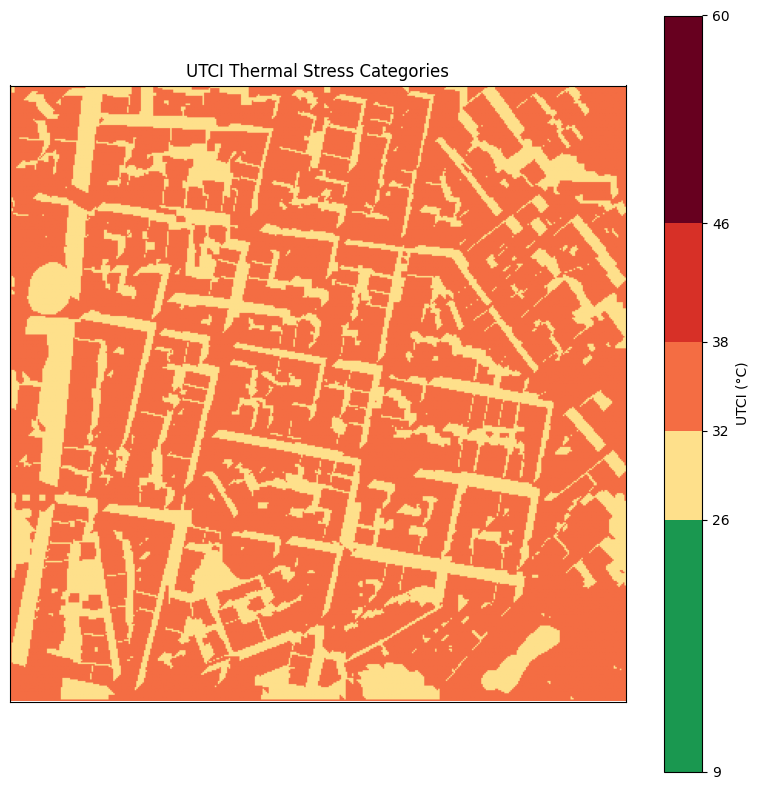

Area by UTCI stress category:
  No stress       (9–26°C):   0.0%
  Moderate        (26–32°C):  28.3%
  Strong          (32–38°C):  71.7%
  Very strong     (38–46°C):   0.0%
  Extreme         (46–60°C):   0.0%


In [4]:
# UTCI stress categories and colours
utci_bounds = [9, 26, 32, 38, 46, 60]
utci_labels = ["No stress", "Moderate", "Strong", "Very strong", "Extreme"]
utci_colors = ["#1a9850", "#fee08b", "#f46d43", "#d73027", "#67001f"]

cmap = ListedColormap(utci_colors)
norm = BoundaryNorm(utci_bounds, cmap.N)

fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(utci, cmap=cmap, norm=norm)
cbar = plt.colorbar(im, ax=ax, ticks=utci_bounds, spacing="proportional")
cbar.set_label("UTCI (°C)")
ax.set_title("UTCI Thermal Stress Categories")
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.show()

# Print area fractions per category
valid = ~np.isnan(utci)
total = valid.sum()
print("Area by UTCI stress category:")
for i, label in enumerate(utci_labels):
    lo, hi = utci_bounds[i], utci_bounds[i + 1]
    frac = ((utci >= lo) & (utci < hi) & valid).sum() / total * 100
    print(f"  {label:15s} ({lo}–{hi}°C): {frac:5.1f}%")

## 4. Shade benefit: sun vs. shade statistics

Quantify how much thermal stress is reduced in shaded areas versus sunlit areas.


In [ ]:
sunlit = shadow > 0.5
shaded = shadow < 0.5

tmrt_sun = np.nanmean(tmrt[sunlit])
tmrt_shd = np.nanmean(tmrt[shaded])
utci_sun = np.nanmean(utci[sunlit])
utci_shd = np.nanmean(utci[shaded])

print("        Sunlit    Shaded    Difference")
print(f"Tmrt:   {tmrt_sun:6.1f}°C  {tmrt_shd:6.1f}°C  {tmrt_sun - tmrt_shd:+6.1f}°C")
print(f"UTCI:   {utci_sun:6.1f}°C  {utci_shd:6.1f}°C  {utci_sun - utci_shd:+6.1f}°C")

## Further reading

- [Thermal Comfort guide](../guide/thermal-comfort.md) — UTCI and PET stress categories, interpretation, and performance
- [Basic Usage guide](../guide/basic-usage.md) — Human parameter customisation, vegetation, anisotropic sky model
- [API Reference](../api/functions.md) — Full function signatures and options
